In [1]:
import pandas as pd
import polars as pl
from sklearn.metrics import average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8
9,Sei,Sei,C9


In [3]:
dataset_renaming = {
    "mendelian_traits_all": "Mendelian traits",
    "complex_traits_all": "Complex traits",
}

subset_renaming = {
    "all": "All",
}

In [4]:
#dataset = "mendelian_traits_all"
dataset = "complex_traits_all"
subset = "all"


features = [
    "CADD",
    #"GPN-MSA_LLR",
    "GPN-MSA_absLLR",

#    "GPN_LLR",
#    "GPN_absLLR",
]

base_dir = f"../../results/dataset/{dataset}"
V = pl.read_parquet(f"{base_dir}/test.parquet")
for feature in features:
    df = pl.read_parquet(f"{base_dir}/features/{feature}.parquet")
    df.columns = [f"{feature}_{col}" for col in df.columns]
    V = pl.concat([V, df], how="horizontal")
subset_df = pl.read_parquet(f"{base_dir}/subset/{subset}.parquet")
V = subset_df.join(V, on=["chrom", "pos", "ref", "alt"], how="left")
V

chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,CADD_RawScore,GPN-MSA_absLLR_score
str,i64,str,str,f64,str,bool,f64,f64,str,f32,f32
"""1""",758351,"""A""","""G""",0.0,"""""",false,0.11581,80.222,"""intron_variant""",0.745346,0.050781
"""1""",772142,"""G""","""C""",0.0,"""""",false,0.097076,73.052,"""intron_variant""",-0.382612,1.642578
"""1""",782207,"""G""","""A""",0.0,"""""",false,0.015778,12.172,"""intron_variant""",0.207167,0.259766
"""1""",787949,"""A""","""T""",0.0,"""""",false,0.0017441,5.0762,"""intron_variant""",0.327236,3.337891
"""1""",794707,"""T""","""C""",0.0,"""""",false,0.056288,50.019,"""intron_variant""",0.611349,1.332031
…,…,…,…,…,…,…,…,…,…,…,…
"""22""",50791377,"""T""","""C""",0.0,"""""",false,0.072962,59.296,"""intron_variant""",0.361089,0.30957
"""22""",50792792,"""A""","""G""",0.0,"""""",false,0.05375,43.457,"""intron_variant""",1.123357,0.059998
"""22""",50795771,"""T""","""C""",0.0,"""""",false,0.000132,45.399,"""intron_variant""",-0.395607,1.624023


In [11]:
V.filter(pl.col("label"))["maf"].plot.hist(bins=50)

:Histogram   [maf]   (maf_count)

In [12]:
V.filter(~pl.col("label"))["maf"].plot.hist(bins=50)

:Histogram   [maf]   (maf_count)

In [13]:
V.filter(pl.col("label"))["maf"].plot.hist(bins=100)

:Histogram   [maf]   (maf_count)

In [14]:
V.filter(~pl.col("label"))["maf"].plot.hist(bins=100)

:Histogram   [maf]   (maf_count)

In [16]:
# just for experimentation
V = V.to_pandas()
V

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,CADD_RawScore,GPN-MSA_absLLR_score
0,1,758351,A,G,0.000000,,False,0.115810,80.2220,intron_variant,0.745346,0.050781
1,1,772142,G,C,0.000000,,False,0.097076,73.0520,intron_variant,-0.382612,1.642578
2,1,782207,G,A,0.000000,,False,0.015778,12.1720,intron_variant,0.207167,0.259766
3,1,787949,A,T,0.000000,,False,0.001744,5.0762,intron_variant,0.327236,3.337891
4,1,794707,T,C,0.000000,,False,0.056288,50.0190,intron_variant,0.611349,1.332031
...,...,...,...,...,...,...,...,...,...,...,...,...
11775253,22,50791377,T,C,0.000000,,False,0.072962,59.2960,intron_variant,0.361089,0.309570
11775254,22,50792792,A,G,0.000000,,False,0.053750,43.4570,intron_variant,1.123357,0.059998
11775255,22,50795771,T,C,0.000000,,False,0.000132,45.3990,intron_variant,-0.395607,1.624023
11775256,22,50798635,T,C,0.001031,,False,0.298370,36.0210,intron_variant,0.363428,2.371094


In [91]:
n_bins = 100
bins = np.linspace(0, 0.5, n_bins + 1)
bins

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  ])

In [92]:
V["maf_bin"] = pd.cut(V.maf, bins=bins, labels=False)

In [93]:
import numpy as np

V_pos = V.query("label")
V_neg = V.query("not label")

len(V), len(V_pos), len(V_neg)

(11775258, 1140, 11774118)

In [94]:
pos_hist = V_pos.maf_bin.value_counts().sort_index().values
pos_hist

array([58, 65, 30, 26, 25, 21, 17, 18, 18, 15, 14, 17, 14, 11, 18, 21,  9,
        3, 12,  8,  6,  7, 10,  5, 10,  8,  8, 11, 10,  9,  9,  7,  6, 13,
       10,  8,  7,  7,  8,  6, 10, 10,  7,  7, 12,  8,  8, 11,  6, 15,  6,
       11, 10, 11, 11, 17,  5, 10, 14, 13,  8, 11, 11,  4,  7, 14,  9,  7,
        8,  9,  9,  9, 10,  7, 10,  8,  6,  6, 10, 14, 14, 12,  6, 17, 14,
        7,  7, 12,  5, 11, 15,  2,  8,  8,  5,  6, 10,  7,  4,  6])

In [96]:
neg_hist = V_neg.maf_bin.value_counts().sort_index().values
neg_hist

array([3050253, 1010013,  572033,  408236,  312958,  254620,  221521,
        193993,  171142,  155765,  145438,  132627,  129057,  116454,
        110227,  104824,  100961,   97621,   92374,   89555,   87031,
         87229,   82973,   81494,   79459,   80764,   74991,   73695,
         70299,   70774,   65960,   67933,   66992,   65331,   65524,
         63787,   63552,   62212,   60368,   59918,   59520,   58190,
         56994,   56492,   56852,   58588,   52536,   53927,   55455,
         53549,   51754,   50659,   52603,   52614,   51189,   51007,
         48905,   48846,   48939,   49587,   49252,   49070,   49001,
         47719,   49093,   47125,   47509,   45853,   45595,   45109,
         46770,   46573,   46663,   45493,   45806,   46063,   45837,
         45635,   44900,   45593,   43805,   43999,   44546,   43613,
         43221,   43682,   41992,   43769,   45386,   45061,   44334,
         43799,   42804,   41391,   44402,   43277,   42075,   43347,
         43403,   43

In [97]:
pos_dist = pos_hist / len(V_pos)
pos_dist

array([0.05087719, 0.05701754, 0.02631579, 0.02280702, 0.02192982,
       0.01842105, 0.01491228, 0.01578947, 0.01578947, 0.01315789,
       0.0122807 , 0.01491228, 0.0122807 , 0.00964912, 0.01578947,
       0.01842105, 0.00789474, 0.00263158, 0.01052632, 0.00701754,
       0.00526316, 0.00614035, 0.00877193, 0.00438596, 0.00877193,
       0.00701754, 0.00701754, 0.00964912, 0.00877193, 0.00789474,
       0.00789474, 0.00614035, 0.00526316, 0.01140351, 0.00877193,
       0.00701754, 0.00614035, 0.00614035, 0.00701754, 0.00526316,
       0.00877193, 0.00877193, 0.00614035, 0.00614035, 0.01052632,
       0.00701754, 0.00701754, 0.00964912, 0.00526316, 0.01315789,
       0.00526316, 0.00964912, 0.00877193, 0.00964912, 0.00964912,
       0.01491228, 0.00438596, 0.00877193, 0.0122807 , 0.01140351,
       0.00701754, 0.00964912, 0.00964912, 0.00350877, 0.00614035,
       0.0122807 , 0.00789474, 0.00614035, 0.00701754, 0.00789474,
       0.00789474, 0.00789474, 0.00877193, 0.00614035, 0.00877

In [98]:
pos_dist_ratio_to_max = pos_dist / pos_dist.max()
pos_dist_ratio_to_max

array([0.89230769, 1.        , 0.46153846, 0.4       , 0.38461538,
       0.32307692, 0.26153846, 0.27692308, 0.27692308, 0.23076923,
       0.21538462, 0.26153846, 0.21538462, 0.16923077, 0.27692308,
       0.32307692, 0.13846154, 0.04615385, 0.18461538, 0.12307692,
       0.09230769, 0.10769231, 0.15384615, 0.07692308, 0.15384615,
       0.12307692, 0.12307692, 0.16923077, 0.15384615, 0.13846154,
       0.13846154, 0.10769231, 0.09230769, 0.2       , 0.15384615,
       0.12307692, 0.10769231, 0.10769231, 0.12307692, 0.09230769,
       0.15384615, 0.15384615, 0.10769231, 0.10769231, 0.18461538,
       0.12307692, 0.12307692, 0.16923077, 0.09230769, 0.23076923,
       0.09230769, 0.16923077, 0.15384615, 0.16923077, 0.16923077,
       0.26153846, 0.07692308, 0.15384615, 0.21538462, 0.2       ,
       0.12307692, 0.16923077, 0.16923077, 0.06153846, 0.10769231,
       0.21538462, 0.13846154, 0.10769231, 0.12307692, 0.13846154,
       0.13846154, 0.13846154, 0.15384615, 0.10769231, 0.15384

In [99]:
neg_hist_max = neg_hist[pos_hist.argmax()]
neg_hist_max

1010013

In [100]:
upper_bound = np.floor(neg_hist_max * pos_dist_ratio_to_max)
upper_bound

array([ 901242., 1010013.,  466159.,  404005.,  388466.,  326311.,
        264157.,  279695.,  279695.,  233079.,  217541.,  264157.,
        217541.,  170925.,  279695.,  326311.,  139847.,   46615.,
        186463.,  124309.,   93231.,  108770.,  155386.,   77693.,
        155386.,  124309.,  124309.,  170925.,  155386.,  139847.,
        139847.,  108770.,   93231.,  202002.,  155386.,  124309.,
        108770.,  108770.,  124309.,   93231.,  155386.,  155386.,
        108770.,  108770.,  186463.,  124309.,  124309.,  170925.,
         93231.,  233079.,   93231.,  170925.,  155386.,  170925.,
        170925.,  264157.,   77693.,  155386.,  217541.,  202002.,
        124309.,  170925.,  170925.,   62154.,  108770.,  217541.,
        139847.,  108770.,  124309.,  139847.,  139847.,  139847.,
        155386.,  108770.,  155386.,  124309.,   93231.,   93231.,
        155386.,  217541.,  217541.,  186463.,   93231.,  264157.,
        217541.,  108770.,  108770.,  186463.,   77693.,  1709

In [101]:
downsample = (neg_hist / upper_bound).min()
downsample

0.1651025715767517

In [102]:
target_n_samples = np.floor(upper_bound * downsample).astype(int)
target_n_samples

array([148797, 166755,  76964,  66702,  64136,  53874,  43613,  46178,
        46178,  38481,  35916,  43613,  35916,  28220,  46178,  53874,
        23089,   7696,  30785,  20523,  15392,  17958,  25654,  12827,
        25654,  20523,  20523,  28220,  25654,  23089,  23089,  17958,
        15392,  33351,  25654,  20523,  17958,  17958,  20523,  15392,
        25654,  25654,  17958,  17958,  30785,  20523,  20523,  28220,
        15392,  38481,  15392,  28220,  25654,  28220,  28220,  43613,
        12827,  25654,  35916,  33351,  20523,  28220,  28220,  10261,
        17958,  35916,  23089,  17958,  20523,  23089,  23089,  23089,
        25654,  17958,  25654,  20523,  15392,  15392,  25654,  35916,
        35916,  30785,  15392,  43613,  35916,  17958,  17958,  30785,
        12827,  28220,  38481,   5130,  20523,  20523,  12827,  15392,
        25654,  17958,  10261,  15392])

In [103]:
V_neg_matched = pd.concat([
    V_neg[V_neg.maf_bin == i].sample(target_n_samples[i], replace=False, random_state=42)
    for i in range(n_bins)
])
V_neg_matched

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,CADD_RawScore,GPN-MSA_absLLR_score,maf_bin
1201938,2,57462871,T,C,0.0,,False,0.000253,156.240,intergenic_variant,-0.301615,1.440430,0
8685356,12,110105824,C,T,0.0,,False,0.001428,10.241,intergenic_variant,-0.234153,1.178711,0
6682991,9,30675884,A,G,0.0,,False,0.004612,14.325,intergenic_variant,0.007553,1.083984,0
10492345,17,53933506,T,C,0.0,,False,0.000103,80.133,intron_variant,0.381275,1.523438,0
3987124,5,93403202,A,G,0.0,,False,0.001336,8.981,CTCF-only,1.658042,4.542969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532908,10,111460477,A,G,0.0,,False,0.497510,312.990,intergenic_variant,0.085837,0.114746,99
4878088,6,103203962,G,A,0.0,,False,0.495740,417.260,intergenic_variant,0.355211,0.916992,99
3661667,5,6109815,C,T,0.0,,False,0.498430,101.880,intergenic_variant,-0.185021,1.083008,99
9464688,14,82961336,C,T,0.0,,False,0.497970,85.037,intergenic_variant,0.269634,2.501953,99


<Axes: >

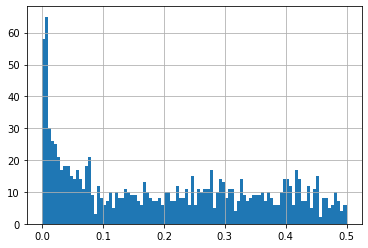

In [104]:
V_pos.maf.hist(bins=bins)

<Axes: >

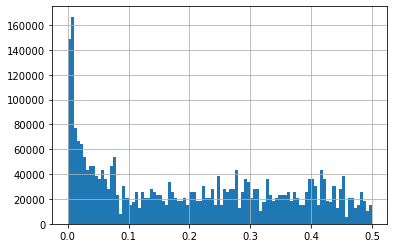

In [105]:
# rounding error??
V_neg_matched.maf.hist(bins=bins)

In [107]:
len(V)

11775258

<Axes: >

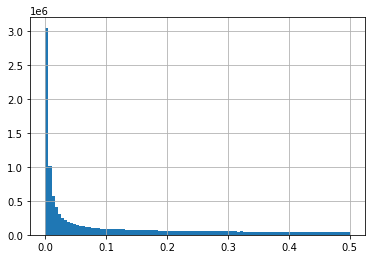

In [106]:
V_neg.maf.hist(bins=bins)

In [12]:
V = V.with_columns(
    pl.col("CADD_RawScore").alias("CADD"),
    #-pl.col("GPN-MSA_LLR_score").alias("GPN-MSA"),
    #-pl.col("GPN_LLR_score").alias("gLM-Promoter"),

    pl.col("GPN-MSA_absLLR_score").alias("GPN-MSA"),
    pl.col("GPN_absLLR_score").alias("gLM-Promoter"),
)
models = [
    "CADD",
    "GPN-MSA",
    "gLM-Promoter",
]

## Bootstrap AUPRC

In [13]:
n_bootstraps = 100
V = V.select(["label"] + models)

def resample(V, seed):
    V_pos = V.filter(pl.col("label"))
    V_pos = V_pos.sample(len(V_pos), with_replacement=True, seed=seed)
    V_neg = V.filter(~pl.col("label"))
    V_neg = V_neg.sample(len(V_neg), with_replacement=True, seed=seed)
    return pl.concat([V_pos, V_neg])

V_bs = [resample(V, i) for i in tqdm(range(n_bootstraps))]

res = []
for model in models:
    def stat(V):
        return average_precision_score(V["label"], V[model])
    se = pl.Series([stat(V_b) for V_b in tqdm(V_bs)]).std()
    res.append([model, stat(V), se])
res = pd.DataFrame(res, columns=["model", "AUPRC", "se"])
res

100%|████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]


,model,AUPRC,se
0,CADD,0.001035,0.000553
1,GPN-MSA,0.000846,0.000144
2,gLM-Promoter,0.000147,0.000004


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


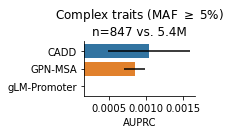

In [14]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

n_pos, n_neg = V["label"].sum(), len(V) - V["label"].sum()
pos_prop = n_pos / len(V)

data = res.sort_values("AUPRC", ascending=False)
plt.figure(figsize=(2,1))
g = sns.barplot(
    data=data,
    y="model",
    x="AUPRC",
    palette=palette,
)
bar_height = g.patches[0].get_height()
y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
g.errorbar(
    x=data["AUPRC"],
    y=y_coords,
    xerr=data["se"],
    fmt='none',
    color="black",
)
g.set(
    ylabel="",
    xlim=pos_prop,
)
ss = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
d = dataset_renaming.get(dataset, dataset)
s = subset_renaming.get(subset, subset)
plt.title(f"{d} ({s})\n{ss}")
sns.despine();
#plt.savefig("../../results/plots/performance_mendelian_all.pdf", bbox_inches="tight")